<a href="https://colab.research.google.com/github/JustMatthew989/Matvey_Mokritskikh_Repo/blob/main/%D0%94%D0%97_7_%D0%9C%D0%BE%D0%BA%D1%80%D0%B8%D1%86%D0%BA%D0%B8%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ДОМАШНЕЕ ЗАДАНИЕ №7

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import optuna
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

df = pd.DataFrame(pd.read_csv(r'C:\Users\snady\.spyder-py3\updated_pollution_dataset.csv'))

df.drop_duplicates(inplace=True)

df.replace('', np.nan, inplace=True)
df.replace([None], np.nan, inplace=True)


for column in df.columns:
    if df[column].nunique() == len(df):
        df.drop(column, axis=1, inplace=True)


X = df.drop('Air Quality', axis=1)
y = df['Air Quality']
imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

ohe = OneHotEncoder(drop='first', sparse_output=False)

encoded_train = pd.DataFrame(
    ohe.fit_transform(X_train[categorical_columns]),
    columns=ohe.get_feature_names_out(categorical_columns)
)
X_train = pd.concat([X_train[numerical_columns], encoded_train], axis=1)

encoded_test = pd.DataFrame(
    ohe.transform(X_test[categorical_columns]),
    columns=ohe.get_feature_names_out(categorical_columns)
)
X_test = pd.concat([X_test[numerical_columns], encoded_test], axis=1)

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [ ]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Training Recall: {train_recall:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")
print()
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

#Делаю вывод - переобучение.

Training Recall: 1.0000
Training Precision: 1.0000
Training F1 Score: 1.0000

Test Recall: 0.9210
Test Precision: 0.9238
Test F1 Score: 0.9218


Fitting 5 folds for each of 20 candidates, totalling 100 fits
F1 Score: 0.9269
Recall: 0.9270
Precision: 0.9276


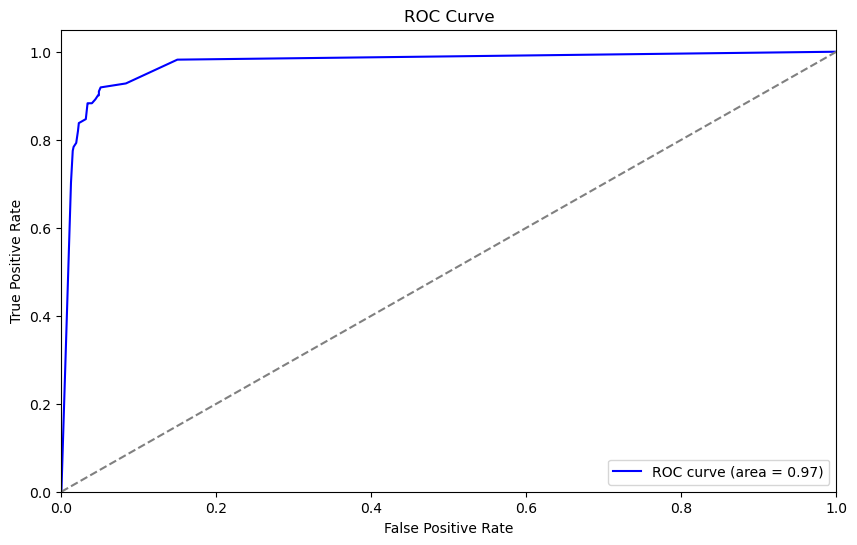

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_leaf': [1, 2, 5, 10]
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

y_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=best_model.classes_[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Делаю следующий вывод: подбор параметров смог побороть переобучение, ура, победа.